# *Работа 6:* Размножающие свойства решетки реактора канального типа

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pyGetera
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import normalize
getera = pyGetera.GeteraInterface(
    getera_path='D:\\bin\\',
    input_file='lab6.txt',
    output_file='lab6.out')

Будем работать с ячейкой канального реактора со следующими параметрами:

* 18 твэлов
* радиус ТВС $50 мм$
* толщина оболочки ТВС $2.5 мм$
* топливо $UO_2$ c обогащение $x=2.0\%$
* Толщина оболочки твэла $\delta_t=0.6 мм$
* диаметр твэла $d=10.0 мм$
* теплоноситель — легкая вода с плотностью $0.7\  г/см^3$

Рассчитаем необходимые ядерные концентрации веществ:

In [2]:
ptop0 = 10.97*6.02*10**(23)/269.928
pcool = 0.7*6.02*10**(23)/18.015
pzam01 = 1.67*6.02*10**(23)/12.011

Rho1 = pd.DataFrame({'x':[2.0]})
Rho1['pzam'] = pzam01
Rho1['ptop'] = ptop0
Rho1['U235'] = (Rho1.x/100)*Rho1.ptop*10**(-24)
Rho1['U238'] = (1-Rho1.x/100)*Rho1.ptop*10**(-24)
Rho1['O']    = 2*Rho1.ptop*10**(-24)
Rho1['Zr']   = 0.0351
Rho1['*H*']  = 2*pcool*10.97**(-24)
Rho1['*O*']  = pcool*10**(-24)
Rho1['C']    = Rho1.pzam*10**(-24)
Rho1['D']    = 0
Acell = 12
d = 1
delta_t = 0.06
TVS_R = 5
delta_TVS = 0.25
Rho1

,x,pzam,ptop,U235,U238,O,Zr,*H*,*O*,C,D
0,2.0,8.370161e+22,2.446556e+22,0.000489,0.023976,0.048931,0.0351,0.005071,0.023392,0.083702,0


## Задание 1
Зададим ячейку с вышеописанными параметрами и с шагом решетки $12\ мм$ и рассчитаем необходимые коэффициенты и макросечения.

In [5]:
to_tex_dict = {
    'keff': r'\(K_{\infty}\)',
    'nu': r'\(\nu\)',
    'mu': r'\(\mu\)',
    'fi': r'\(\varphi\)',
    'teta': r'\(\vartheta\)',
    '3::sabs2': r'\(\Sigma_{a}^{топ}\)',
    '1::sabs2': r'\(\Sigma_{a}^{зам}\)',
    '1::nusfis2': r'\(\nu_f\Sigma_f\)',
}

def lab6(step):
    #меняем радиусы
    getera.input(
        {
            'rcel(1,1)':[0.75],
            'rcel(1,2)':[d/2 - delta_t, d/2, 1],
            'rcel(1,3)':[5.0,5.6,6.5,9.,11.3, step, 'rcin(3)=4.75']
        }, 
        reg_exp=r'\s+rcel\(\d,\d\)=')
    
    #меняем концентрации 
    getera.input({
        'u235': [Rho1['U235'][0], 0,              0,              0],
        'u238': [Rho1['U238'][0], 0,              0,              0],
        'o':    [Rho1['O'][0],    0,              0,              0],
        'zr':   [0,               Rho1['Zr'][0],  0,              0],
        '*h*':  [0,               0,              Rho1['*H*'][0], 0],
        '*o*':  [0,               0,              Rho1['*O*'][0], 0],
        'c':    [0,               0,              0,              Rho1['C'][0]]
    })
    
    result = getera.output(
                        format='pandas', 
                        columns=[
                            'keff', 'teta','fi',
                            '3::sabs2', '1::sabs2', 
                            '1::nusfis2'
                            ]
                    )
    return result


result = lab6(12)
display(result.rename(columns=to_tex_dict))

,\(K_{\infty}\),\(\vartheta\),\(\varphi\),\(\Sigma_{a}^{топ}\),\(\Sigma_{a}^{зам}\),\(\nu_f\Sigma_f\)
0,1.3372,0.92487,0.78589,0.00311,0.003153,0.0


## Задание 2
Найдем теперь оптимальный шаг решетки:

a optimum for H_2O 16.499999999999993


,\(K_{\infty}\),\(\vartheta\),\(\varphi\),\(\Sigma_{a}^{топ}\),\(\Sigma_{a}^{зам}\),\(\nu_f\Sigma_f\)
0,1.3769,0.91001,0.83499,0.003201,0.003246,0.0
10,1.3867,0.90174,0.85278,0.003235,0.003281,0.0
20,1.3914,0.89297,0.86739,0.003264,0.003310,0.0
30,1.3922,0.88377,0.87949,0.003288,0.003334,0.0
40,1.3896,0.87417,0.88962,0.003308,0.003355,0.0
50,1.3844,0.86420,0.89817,0.003325,0.003373,0.0


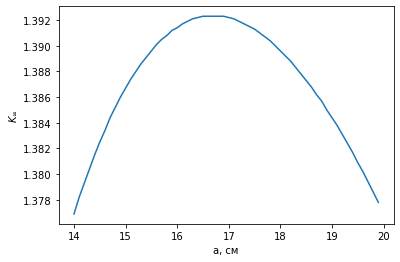

In [6]:
def find_opt(acellRange, tag, lab, is_plot=True):
    list_of_res = []
    for r in acellRange:
        list_of_res.append(lab(r))
    results = pd.concat(list_of_res, axis=0, ignore_index=True)
    if is_plot:
        pl.plot(acellRange, results['keff'])
        pl.xlabel('a, cм')
        pl.ylabel('$K_{\infty}$')
    print(fr"a optimum for {tag}", acellRange[np.argmax(results['keff'])])
    display(results.rename(columns=to_tex_dict)[::10])
    return results

acellRange = np.arange(14, 20, 0.1)
results1 = find_opt(acellRange, 'H_2O', lab6)


## Задание 3
Преобразуем входной файл и рассчитаем концентрации для ячейки, содержащей в качестве замедлителя и теплоносителя тяжелую воду, а в качестве топлива — $UO_2$ с обогащением $0.71\%$

Расчитаем концентрации:

In [7]:
pzam01 = 1.11*6.02*10**(23)/20.0278

Rho1 = pd.DataFrame({'x':[0.7]})
Rho1['pzam'] = pzam01
Rho1['ptop'] = ptop0
Rho1['U235'] = (Rho1.x/100)*Rho1.ptop*10**(-24)
Rho1['U238'] = (1-Rho1.x/100)*Rho1.ptop*10**(-24)
Rho1['O']    = 2*Rho1.ptop*10**(-24)
Rho1['Zr']   = 0.0351
Rho1['*H*']  = 0
Rho1['*O*']  = Rho1.pzam*10**(-24)
Rho1['C']    = 0
Rho1['D']    = 2*Rho1.pzam*10**(-24)
Rho1

,x,pzam,ptop,U235,U238,O,Zr,*H*,*O*,C,D
0,0.7,3.336462e+22,2.446556e+22,0.000171,0.024294,0.048931,0.0351,0,0.033365,0,0.066729


Зададим ячейку и найдем оптимальный шаг:

a optimum for D_2O 16.399999999999995


,\(K_{\infty}\),\(\vartheta\),\(\varphi\),\(\Sigma_{a}^{топ}\),\(\Sigma_{a}^{зам}\),\(\nu_f\Sigma_f\)
0,1.1772,0.95866,0.93267,0.003563,0.003617,0.0
10,1.1786,0.95624,0.93645,0.003575,0.003629,0.0
20,1.1786,0.95370,0.93919,0.003580,0.003634,0.0
30,1.1776,0.95101,0.94120,0.003584,0.003638,0.0
40,1.1759,0.94817,0.94270,0.003587,0.003641,0.0


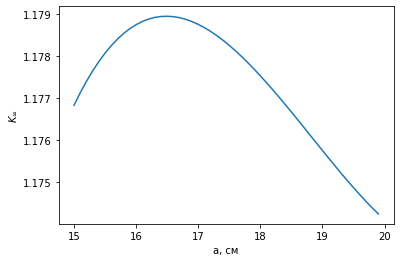

In [12]:
def lab61(step):
    #меняем радиусы
    getera.input({
        'rcel(1,1)':[0.75],
        'rcel(1,2)':[d/2 - delta_t, d/2, 1],
        'rcel(1,3)':[4.8,7.4,8.5,11.5,14.5, step, 'rcin(3)=4.75'],
    }, reg_exp=r'\s+rcel\(\d,\d\)=')
    
    #меняем концентрации 
    getera.input({
        'u235': [Rho1['U235'][0], 0,              0,              0],
        'u238': [Rho1['U238'][0], 0,              0,              0],
        'o':    [Rho1['O'][0],    0,              0,              0],
        'zr':   [0,               Rho1['Zr'][0],  0,              0],
        'd':    [0,               0,              Rho1['D'][0],   Rho1['D'][0]],
        '*o*':  [0,               0,              Rho1['*O*'][0], Rho1['*O*'][0]]
    })
    
    result = getera.output(format='pandas',
                           columns=['keff', 'teta','fi', '3::sabs2',
                                    '1::sabs2', '1::nusfis2'] )

    return result
acellRange2 = np.arange(15, 20, 0.1)
results2 = find_opt(acellRange2, 'D_2O', lab61, is_plot=False)

regr = KernelRidge(kernel='poly', alpha = 0.000008)
regr.fit(acellRange2.reshape(-1, 1),results2['keff'].values.ravel())


pl.plot(acellRange2, regr.predict(acellRange2.reshape(-1, 1)))
pl.xlabel('a, cм')
pl.ylabel('$K_{\infty}$')
pl.show()

Общий график:

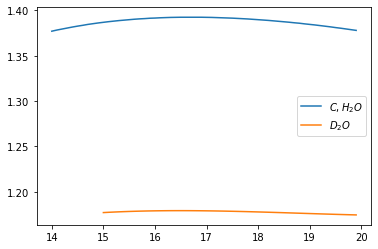

In [13]:
pl.plot(acellRange, results1['keff'], label='$C, H_2O$')
pl.plot(acellRange2, 
        regr.predict(acellRange2.reshape(-1, 1)), label='$D_2O$')
pl.legend()
pl.show()